# A Framework for Leveraging LLMs for Scene Analysis and Cognitive Processing

## Setup

In [6]:
import os
HOME = os.getcwd()

os.chdir(HOME)
print(HOME)

/Users/162191/Documents/GitHub/human_patterns_exploration


In [7]:
import os
HOME = os.getcwd()

import openai
import ollama

import time
import base64

import numpy as np

from classes.ImageData import ImageData

import pandas as pd

from IPython.display import display, HTML

from utils.llm_utils import *
from utils.experiment_data import *

import utils.style as stl
from utils.experiment_utils import *

import matplotlib.pyplot as plt

from utils.prompts import *

import pickle

In [8]:

DATA_DIR = os.path.join(HOME, "data", "experiments")
IMAGE_DIR = os.path.join(HOME, "data", "images")
RESULTS_DIR = os.path.join(HOME, "outputs")

SAM_CONFIG = os.path.join("configs", "sam2.1", "sam2.1_hiera_l.yaml")
SAM_MODEL =  os.path.join(HOME, "checkpoints", "sam2.1_hiera_large.pt")

print("HOME:", HOME)
print("DATA_DIR:", DATA_DIR)
print("IMAGE_DIR:", IMAGE_DIR)
print("SAM_CONFIG:", SAM_CONFIG)
print("SAM_MODEL:", SAM_MODEL)

HOME: /Users/162191/Documents/GitHub/human_patterns_exploration
DATA_DIR: /Users/162191/Documents/GitHub/human_patterns_exploration/data/experiments
IMAGE_DIR: /Users/162191/Documents/GitHub/human_patterns_exploration/data/images
SAM_CONFIG: configs/sam2.1/sam2.1_hiera_l.yaml
SAM_MODEL: /Users/162191/Documents/GitHub/human_patterns_exploration/checkpoints/sam2.1_hiera_large.pt


## Participant Gaze

In [9]:
prompt_diameter = 10
prompt_n_points = 5

# colors for eye gaze plots
font_color =  "yellow"          
COLOR_CODE_1 = "fixation_scarletred_meddark"
COLOR_CODE_2 = "aluminium"
COLOR_CODE_3 = "yellow"

In [10]:
# load experiment data
data_path = os.path.join(DATA_DIR , "XSQ_Expt1_Data_2.csv")
data = pd.read_csv( data_path )
data.head()


,ParticipantID,Group,Condition,ItemNum,X,Y,FixationDuration,Rel_Scene_Region_Rel_X1,Rel_Scene_Region_Rel_Y1,Rel_Scene_Region_Rel_X2,...,Irrev_Scene_Region_X1,Irrev_Scene_Region_Y1,Irrev_Scene_Region_X2,Irrev_Scene_Region_Y2,Irrev_Scene_Region_IrrelSceneFix,Cntl_Scene_Region_X1,Cntl_Scene_Region_Y1,Cntl_Scene_Region_X2,Cntl_Scene_Region_Y2,Cntl_Scene_Region_CntlSceneFix
0,2,1,1,1,398.0,314.2,291,0.0,464.0,800.0,...,0.0,0.0,800.0,247.0,0.0,0.0,380.0,800.0,680.0,0.0
1,2,1,1,1,323.4,398.2,421,0.0,464.0,800.0,...,0.0,0.0,800.0,247.0,0.0,0.0,380.0,800.0,680.0,1.0
2,2,1,1,1,23.6,492.2,268,0.0,464.0,800.0,...,0.0,0.0,800.0,247.0,0.0,0.0,380.0,800.0,680.0,1.0
3,2,1,1,1,483.6,565.0,162,0.0,464.0,800.0,...,0.0,0.0,800.0,247.0,0.0,0.0,380.0,800.0,680.0,1.0
4,2,1,1,2,379.6,305.1,206,0.0,435.0,800.0,...,0.0,0.0,800.0,247.0,0.0,0.0,380.0,800.0,680.0,0.0


## Image Segmentation and Mask Generation

In [6]:
CENTER_BIAS_SECONDS = 1    # remove first 1 second of data to remove center bias

prompt_types = ["point", "circle", "triangle", "cross"]

GENERATE_MASKS = False

if GENERATE_MASKS:      
    for img_id in range(1, 2):
        for prompt_type in prompt_types:
            image_data = segment_image(img_id, data, condition_id=1, center_bias_seconds=CENTER_BIAS_SECONDS, prompt_type=prompt_type,  img_type="exp")
            #image_data = segment_image(img_id, data, condition_id=3, center_bias_seconds=CENTER_BIAS_SECONDS, prompt_type=prompt_type,  img_type="unexp")


### Find the best mask for each participant

In [39]:
IMG_ID = 1
IMG_TYPE = "exp"
PROMPT_TYPE = "point"

participant_ids = get_participant_ids( os.path.join(RESULTS_DIR, "masks_gaze_driven", PROMPT_TYPE) , IMG_TYPE) 
print("Total participants: ", len(participant_ids))


Total participants:  17


20


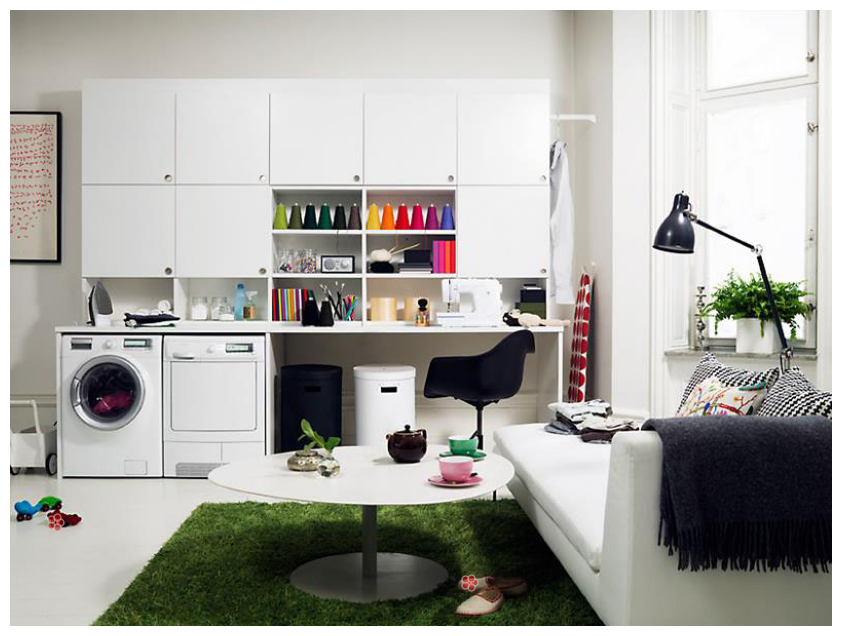

In [8]:
P_INDX = 3
print(participant_ids[P_INDX])
img_data, participant_data = load_image_data(IMG_ID, IMG_TYPE, participant_id=participant_ids[P_INDX], prompt_type=PROMPT_TYPE)

img_data.draw_fixations( participant_data, fix_color=stl.COLORS[COLOR_CODE_1][0], fix_edge_color=stl.COLORS[COLOR_CODE_2][1], size = 25 )


Processing mask 0 for participant 15


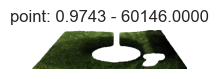

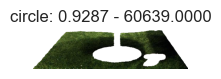

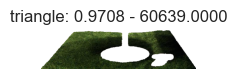

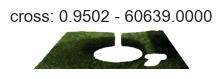

Processing mask 1 for participant 15


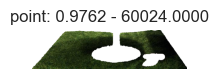

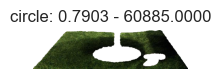

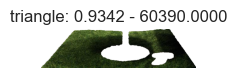

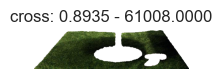

Processing mask 2 for participant 15


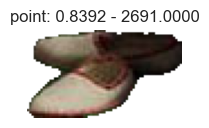

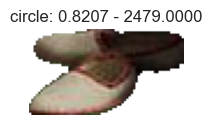

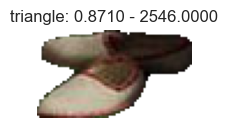

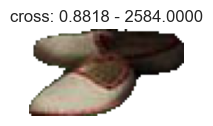

In [9]:
get_mask_candidates(1, 15, prompt_types, "exp")


In [ ]:
find_best_mask(IMG_ID, participant_ids, prompt_types, IMG_TYPE)


In [10]:
P_INDX = 0
img_scene_data, participant_data = load_image_data(IMG_ID, IMG_TYPE, participant_id=participant_ids[P_INDX], prompt_type=PROMPT_TYPE)

In [11]:
def label_masks_openai(participant_ids, num_images, img_type, model="gpt-4o", filename = "best_labels", output_dir = os.path.join(RESULTS_DIR, "masks_gaze_driven", "best_mask_labeling") ):

    df = pd.DataFrame(columns=["participant_id", "image_id", "image_path", "mask_id", "mask_path", "xmin", "xmax", "ymin", "ymax", "prompt_type", "X", "Y", "label1", "label2", "label3", "label4", "label5", "label6", "label7", "label8", "label9", "label10", "best_label", "scene_desc"])

    row = 0
    for part_indx in range(len(participant_ids)):

        print(f"Processing participant {part_indx}/{len(participant_ids)}")
        participant_id = participant_ids[part_indx]

        for img_id in range(1, num_images+1):

            img_scene_data, _ = load_image_data(img_id, img_type, participant_id=participant_id, prompt_type="point")
            image_path = img_scene_data.path

            scene_desc = open_ai_scene_description(img_scene_data, temperature=0.1)
            scene_desc = scene_desc.replace("*", "")

            res = load_best_masks(img_id, participant_id, IMG_TYPE)

            mask_keys = list(res.keys())
            labels = []
            for mask_key in mask_keys:
                mask_id = mask_key
                mask_path = res[mask_id].path
                xmin = res[mask_id].x_min
                xmax = res[mask_id].x_max
                ymin = res[mask_id].y_min
                ymax = res[mask_id].y_max
                prompt_type = res[mask_id].prompt_type
                prompt = res[mask_id].prompt[0]
                
                for i in range(1, 11):
                    mask_label = open_ai_mask_labeling(res[mask_id], temperature=0.1)

                    # if mask label is of type list, then append the first element to the labels list
                    if isinstance(mask_label, list):
                        labels.append(mask_label[0].replace("- ", ""))
                    else:
                        labels.append(mask_label.replace("- ", ""))
                
                print(labels)

                # get the most frequent label from the list
                best_label = most_frequent_label(labels)

                df.loc[row] = [participant_id, img_id, image_path, mask_id, mask_path, xmin, xmax, ymin, ymax, prompt_type, prompt[0],prompt[1],labels[0], labels[1], labels[2], labels[3], labels[4], labels[5], labels[6], labels[7], labels[8], labels[9], best_label, scene_desc]
                row += 1
                labels = []
    
    df.to_csv(os.path.join(output_dir, f"{filename}_{model}_{IMG_TYPE}.csv"), index=False)
    return df


from collections import Counter

def most_frequent_label(labels):
    if not labels:
        return None  # Return None if the list is empty
    
    label_counts = Counter(labels)
    most_common_label, _ = label_counts.most_common(1)[0]  # Get the most frequent label
    
    return most_common_label


In [ ]:
df =  label_masks_openai(participant_ids, 1, "exp", model="gpt-4o", output_dir = os.path.join(RESULTS_DIR, "masks_gaze_driven", "best_mask_labeling") )


In [12]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 3.9 MB/s eta 0:00:00a 0:00:01


Animation saved to fixation_animation.mp4


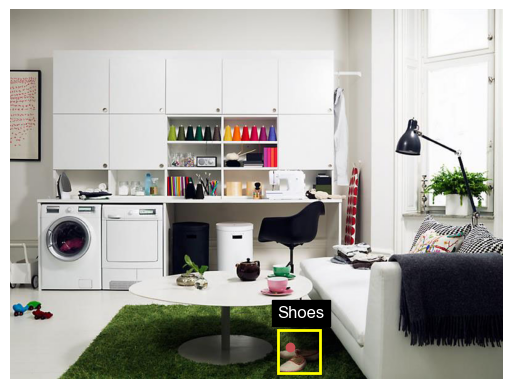

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import imageio.v2 as imageio
from PIL import Image
from matplotlib.animation import FuncAnimation, FFMpegWriter
import os

def animate_fixations(csv_path, participant_id, output_path):
    # Load the dataset
    df = pd.read_csv(csv_path)
    
    # Filter data for the given participant_id
    df_participant = df[df['participant_id'] == participant_id].copy()
    
    if df_participant.empty:
        print(f"No data found for participant {participant_id}")
        return
    
    # Ensure X, Y, bbox coordinates are valid (not NaN and numeric)
    df_participant.dropna(subset=['X', 'Y', 'xmin', 'xmax', 'ymin', 'ymax', 'best_label'], inplace=True)
    df_participant[['X', 'Y', 'xmin', 'xmax', 'ymin', 'ymax']] = df_participant[['X', 'Y', 'xmin', 'xmax', 'ymin', 'ymax']].apply(pd.to_numeric, errors='coerce')
    
    if len(df_participant) < 2:
        print(f"Not enough valid fixation points for animation (found {len(df_participant)}).")
        return
    
    # Load the image and check if it exists
    image_path = df_participant.iloc[0]['image_path']
    if not os.path.exists(image_path):
        print(f"Image file not found: {image_path}")
        return
    
    image = Image.open(image_path)
    
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.grid(False)
    ax.axis('off')
    
    # Initialize elements
    fixation_dot, = ax.plot([], [], 'ro', markersize=6)
    bbox_patch = patches.Rectangle((0, 0), 0, 0, linewidth=2, edgecolor='yellow', facecolor='none')
    ax.add_patch(bbox_patch)
    label_text = ax.text(10, 10, '', fontsize=12, color='white', backgroundcolor='black')
    
    def update(frame):
        if frame >= len(df_participant):
            return []  # Avoid out-of-range error
        
        row = df_participant.iloc[frame]
        
        # Ensure numeric values
        try:
            x, y = float(row['X']), float(row['Y'])
            xmin, xmax, ymin, ymax = float(row['xmin']), float(row['xmax']), float(row['ymin']), float(row['ymax'])
        except ValueError:
            print(f"Invalid numeric values in frame {frame}, skipping.")
            return []
        
        # Update fixation dot
        fixation_dot.set_data([x], [y])  # Ensuring sequence format
        
        # Update bounding box
        bbox_patch.set_xy((xmin, ymin))
        bbox_patch.set_width(xmax - xmin)
        bbox_patch.set_height(ymax - ymin)
        
        # Update label text
        label_text.set_text(row['best_label'])
        label_text.set_position((xmin, ymin-20))
        
        return fixation_dot, bbox_patch, label_text
    
    ani = FuncAnimation(fig, update, frames=len(df_participant), interval=10000, repeat=False)
    
    # Save animation to MP4 with error handling
    try:
        writer = FFMpegWriter(fps=10, metadata={"artist": "Matplotlib"})
        ani.save(output_path, writer=writer)
        print(f"Animation saved to {output_path}")
    except Exception as e:
        print(f"Error saving animation: {e}")
    
    plt.show()
    
    return ani

# Example usage:
csv_file = os.path.join(RESULTS_DIR, "masks_gaze_driven", "best_mask_labeling", "best_labels_gpt-4o_exp.csv")
participant_id = 32
output_video = "fixation_animation.mp4"
animate_fixations(csv_file, participant_id, output_video)


In [ ]:

# Step 2: Label the mask based on the scene context
mask_prompt = f"""You previously analyzed the main scene and described it as follows:
{scene_desc}
Now, analyze the new image, which is a **subset** (masked portion) of the main scene.
Your task:
1. Identify the object(s) in the masked region.
2. Assign the most contextually appropriate label based on the previous scene analysis.
3. If uncertain, explain the possible interpretations based on the overall scene.

Respond with:
- **Detected Object:** [Object Name]
- **Scene Context:** [Why it is likely this object based on the full scene]
"""

start_time = time.time()
mask_resp, mask_label, mask_duration = llava.analyse_image(img_mask_data, mask_prompt, temperature=0.1)
print("Mask Processed in:", time.time() - start_time, "sec")

# Output results
print("Main Scene Description:\n", scene_desc)
print("\nMask Labeling:\n", mask_label)
